In [1]:
import glob
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import concatenate_images, imread, imread_collection, imshow
from skimage.transform import resize
from matplotlib import patches

from config import Config
from mrcnn_data_api_v2 import Mrcnn_Data_API
from mrcnn_api import Mrcnn_API
import utils
import model as modellib

/home/w/anaconda3/envs/idp3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class GISSConfig(Config):

    NAME = "giss_depth_CW01"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 1 + 6
    CHOSEN_CLASS = 1
    CHOSEN_CLASS_WEIGHT = 0.1

    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    IMAGE_CHANNELS = 3
    IMAGE_PADDING = True

    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 128
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)
    RPN_NMS_THRESHOLD = 0.7
    DETECTION_MAX_INSTANCES = 128
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0001
    USE_RPN_ROIS = True
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])
    STEPS_PER_EPOCH = 26
    VALIDATION_STEPS = 7

    
class InferenceConfig(GISSConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [3]:
# Out-of-memory dataset definition.

class GISSDataset(utils.Dataset):

    def load_data(self, src):

        self.add_class("giss", 1, "car")
        self.add_class("giss", 2, "building")
        self.add_class("giss", 3, "human")
        self.add_class("giss", 4, "truck")
        self.add_class("giss", 5, "container")
        self.add_class("giss", 6, "winter-car")
        
        src_images = src + 'images/'
        src_masks = src + 'masks/'
        
        image_names = pd.read_pickle('{}/image_names_processed.pkl'.format(src_images))
        image_shapes = pd.read_pickle('{}/image_shapes_processed.pkl'.format(src_images))
        image_classes = pd.read_pickle('{}/image_classes_processed.pkl'.format(src_images))
        
        for i in range(len(image_names)):
            image_path = '{}{}_processed.pkl'.format(src_images, image_names[i].split('.')[0])
            mask_path = '{}{}_processed.pkl'.format(src_masks, image_names[i].split('.')[0])
            self.add_image("giss", 
                           image_id=image_names[i], 
                           path=image_path,
                           mask_path=mask_path,
                           classes=image_classes[i],
                           shape=image_shapes[i])
        
    def load_image(self, image_id):
        info = self.image_info[image_id]
        return pd.read_pickle(info['path'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        class_ids = np.asarray(info['classes'])
        return pd.read_pickle(info['mask_path']), class_ids.astype(np.int32)

## Data API:


### configuration:

In [4]:
set_filename_train = '2018-01-18_resized_deg90_100m_part1'  # Set containing depth maps for subset of images.
set_filename_valid = '2018-01-18_resized_deg0_part2_zlomowisko'  # Set without depth maps.
mode = 'train'


src_basic = '/home/w/Projects/PW-GISS/data/data/giss_images/resized/'
src_depth_basic = '/home/w/Projects/PW-GISS/data/data/detector-depth/'
src_y = '/home/w/Projects/PW-GISS/data/models/labels/2018-03-01_resized_degX_combined/\
train_2018-03_01_resized_degX_combined.csv'


giss_data_config = {
    'src': src_basic,  # Directory containing folders with sets of images.
    'set_filename': set_filename_train,  # Name of subset directory, which will be used.
    'src_images': '{}{}/'.format(src_basic, set_filename_train),  # Directory from which RGB images are loaded, should be combination of src_basic and set_filename.
    'src_depth': '{}{}/'.format(src_depth_basic, set_filename_train),  # Directory from which depth maps are loaded, should be combination of src_basic and set_filename.
    'dst': '{}{}/'.format(src_basic, set_filename_train),  # Directory, to which processed masks are saved as .pkl files.
    'y': src_y,  # Dataframe consisting of bounding boxes for objects in images.
    'dataset_config': GISSDataset,  # Dataset configuration for MRCNN training.
    'image_filetype': 'JPG',  # Image filetype, for which data API looks, set to '*' to look for all types.
    'image_shape': (1024, 1024),  # Maximum shape of image used for model training. Images are resized and padded to this size.
    'save': True,  # Whether to save .pkl files after processing of images and creation of masks.
    'add_depth_map': False,  # Whether to add depth maps for chosen set of images. Set intersection of RGB and depth maps is used for training in such case.
    'mode': mode,  # Mode, should be 'train' or 'test'. With 'train' training and validation datasets are created.
    'valid_split_size': 0.2,  # Fraction of dataset size to be used for validation.
}

giss_data_config_valid = {
    'src': src_basic,  # Directory containing folders with sets of images.
    'set_filename': set_filename_valid,  # Name of subset directory, which will be used.
    'src_images': '{}{}/'.format(src_basic, set_filename_valid),  # Directory from which RGB images are loaded, should be combination of src_basic and set_filename.
    'src_depth': '{}{}/'.format(src_depth_basic, set_filename_valid),  # Directory from which depth maps are loaded, should be combination of src_basic and set_filename.
    'dst': '{}{}/'.format(src_basic, set_filename_valid),  # Directory, to which processed masks are saved as .pkl files.
    'y': src_y,  # Dataframe consisting of bounding boxes for objects in images.
    'dataset_config': GISSDataset,  # Dataset configuration for MRCNN training.
    'image_filetype': 'JPG',  # Image filetype, for which data API looks, set to '*' to look for all types.
    'image_shape': (1024, 1024),  # Maximum shape of image used for model training. Images are resized and padded to this size.
    'save': True,  # Whether to save .pkl files after processing of images and creation of masks.
    'add_depth_map': False,  # Whether to add depth maps for chosen set of images. Set intersection of RGB and depth maps is used for training in such case.
    'mode': mode,  # Mode, should be 'train' or 'test'. With 'train' training and validation datasets are created.
    'valid_split_size': 0.2,  # Fraction of dataset size to be used for validation.
}


api_data = Mrcnn_Data_API(
    image_shape=giss_data_config['image_shape'],
    resize_and_pad=True,  # Whether to resize and pad images to specified image_shape.
    verbose=True)  # Whether to show progress of files processing.

### Log data processing & model parameters:

In [5]:
import logging

run_name = 'MRCNN_weights_check'

logging.basicConfig(filename='{0}{1}.log'.format('logs/', run_name),
                    level=logging.INFO,
                    format='%(levelname)s:\n%(message)s')

logging.info('Training API parameters:\n{}\n'.format(giss_data_config))
logging.info('Validation API parameters:\n{}\n'.format(giss_data_config_valid))
GISSConfig().save_log(logging)

## Option 1 - training out-of-memory


### Masks creation from bounding boxes coordinates (needed only once per image set):

### Prepare MRCNN datasets:

In [8]:
plt.rcParams['figure.figsize'] = (12, 9)


# Create MRCNN datasets from processed data:

if mode == 'train':
    dataset_train, dataset_val = api_data.prepare_mrcnn_dataset_dir(
        src1=giss_data_config['src_images'],  # Training directory source
        src2=giss_data_config_valid['src_images'],  # Validation directory source
        mode=giss_data_config['mode'],
        dataset_config=giss_data_config['dataset_config'])

    print(len(dataset_train.image_info), len(dataset_val.image_info))

if mode == 'test':
    dataset_test = api_data.prepare_mrcnn_dataset_dir(
        src1=giss_data_config_valid['src_images'],  # Validation directory source
        mode=giss_data_config_valid['mode'],
        dataset_config=giss_data_config_valid['dataset_config'])

    print(len(dataset_test.image_info))


Preparing MRCNN datasets.

Preparing training and validation sets.
Number of training images : 29
Number of validation images : 18

29 18


## Option 2 - training in-memory

### Masks creation and saving (pickle per set, needed only once per image set):

### Loading saved .pkl files:

### Prepare MRCNN datasets:

## Training API:

Works for 3-channel and 4-channel data.

### configuration:

In [9]:
# Automatically derive part of configuration based on dataset properties:

GISSConfig.IMAGE_CHANNELS = dataset_train.image_info[0]['shape'][-1]  # Set number of channels to number of channels in image in training set.
GISSConfig.STEPS_PER_EPOCH = len(dataset_train.image_info)  # Set number of steps per epoch to number of images in training set.
GISSConfig.VALIDATION_STEPS = len(dataset_val.image_info)  # Set number of validation steps to number of images in validation set.
print('Number of channels in configuration set to: {}'.format(GISSConfig.IMAGE_CHANNELS))
if GISSConfig.IMAGE_CHANNELS == 4:
    print('Using 4-channel data.')
    GISSConfig.MEAN_PIXEL = np.append(GISSConfig.MEAN_PIXEL, 0.)  # Append 0. to mean pixel channels, when using 4-channel data.
    GISSConfig.NAME = 'giss_depth1'
    

inference_config = InferenceConfig()


giss_training_config = {
    'config': GISSConfig(),  # Parameters for MRCNN training configuration.
    'image_shape': (1024, 1024),  # Maximum image size for training, should corresponds to the same parameter in data API.
    'resize_and_pad': True,  # Whether to resize and pad to specified image_shape.
    'mrcnn_init': 'coco',  # Training initialization - 'coco' or 'last'.
    'mrcnn_weights_file': 'mask_rcnn_coco.h5'  # Training weights filename, set to mask_rcnn_coco.h5 for 3 channels, mask_rcnn_coco_4ch.h5 for 4 channels, when using 'coco' init.
}

api_training = Mrcnn_API(
    config=giss_training_config['config'],
    image_shape=giss_training_config['image_shape'],
    resize_and_pad=giss_training_config['resize_and_pad'],
    verbose=True)


# Save training configuration:
# utils.save_parameter_dict('GISS_MRCNN_API_parameters.txt', giss_training_config)
logging.info('MRCNN training API parameters:\n{}\n'.format(giss_training_config))

Number of channels in configuration set to: 3


### training:

- Epoch 1/3
29/29 [==============================] - 24s 813ms/step - loss: 2.7186 - rpn_class_loss: 0.1680 - rpn_bbox_loss: 0.7017 - mrcnn_class_loss: 0.8963 - mrcnn_bbox_loss: 0.7209 - mrcnn_mask_loss: 0.2317 - val_loss: 3.1533 - val_rpn_class_loss: 0.1589 - val_rpn_bbox_loss: 0.4239 - val_mrcnn_class_loss: 1.3779 - val_mrcnn_bbox_loss: 0.7824 - val_mrcnn_mask_loss: 0.4102
- Epoch 2/3
29/29 [==============================] - 12s 425ms/step - loss: 1.2783 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.5195 - mrcnn_bbox_loss: 0.3817 - mrcnn_mask_loss: 0.0137 - val_loss: 2.5624 - val_rpn_class_loss: 0.1078 - val_rpn_bbox_loss: 0.3177 - val_mrcnn_class_loss: 1.3805 - val_mrcnn_bbox_loss: 0.7181 - val_mrcnn_mask_loss: 0.0383
- Epoch 3/3
29/29 [==============================] - 12s 424ms/step - loss: 1.0008 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.2405 - mrcnn_class_loss: 0.4386 - mrcnn_bbox_loss: 0.2718 - mrcnn_mask_loss: 0.0062 - val_loss: 2.4325 - val_rpn_class_loss: 0.0859 - val_rpn_bbox_loss: 0.2987 - val_mrcnn_class_loss: 1.4408 - val_mrcnn_bbox_loss: 0.5933 - val_mrcnn_mask_loss: 0.0138


- Epoch 4/5
29/29 [==============================] - 48s 2s/step - loss: 0.7870 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.2023 - mrcnn_class_loss: 0.3359 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.0018 - val_loss: 2.2592 - val_rpn_class_loss: 0.0808 - val_rpn_bbox_loss: 0.8384 - val_mrcnn_class_loss: 0.8322 - val_mrcnn_bbox_loss: 0.4461 - val_mrcnn_mask_loss: 0.0618
- Epoch 5/5
29/29 [==============================] - 21s 722ms/step - loss: 0.7623 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1580 - mrcnn_class_loss: 0.3653 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.0020 - val_loss: 1.6873 - val_rpn_class_loss: 0.0854 - val_rpn_bbox_loss: 0.7161 - val_mrcnn_class_loss: 0.6108 - val_mrcnn_bbox_loss: 0.2584 - val_mrcnn_mask_loss: 0.0166

### inference (prediction):

Loading weights from: logs/giss_depth_cw0120180521T1531/mask_rcnn_giss_depth_cw01_0005.h5
Processing 1 images
image                    shape: (750, 1000, 3)        min:    0.00000  max:  254.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000
Time it took for inference: 3.6111631393432617


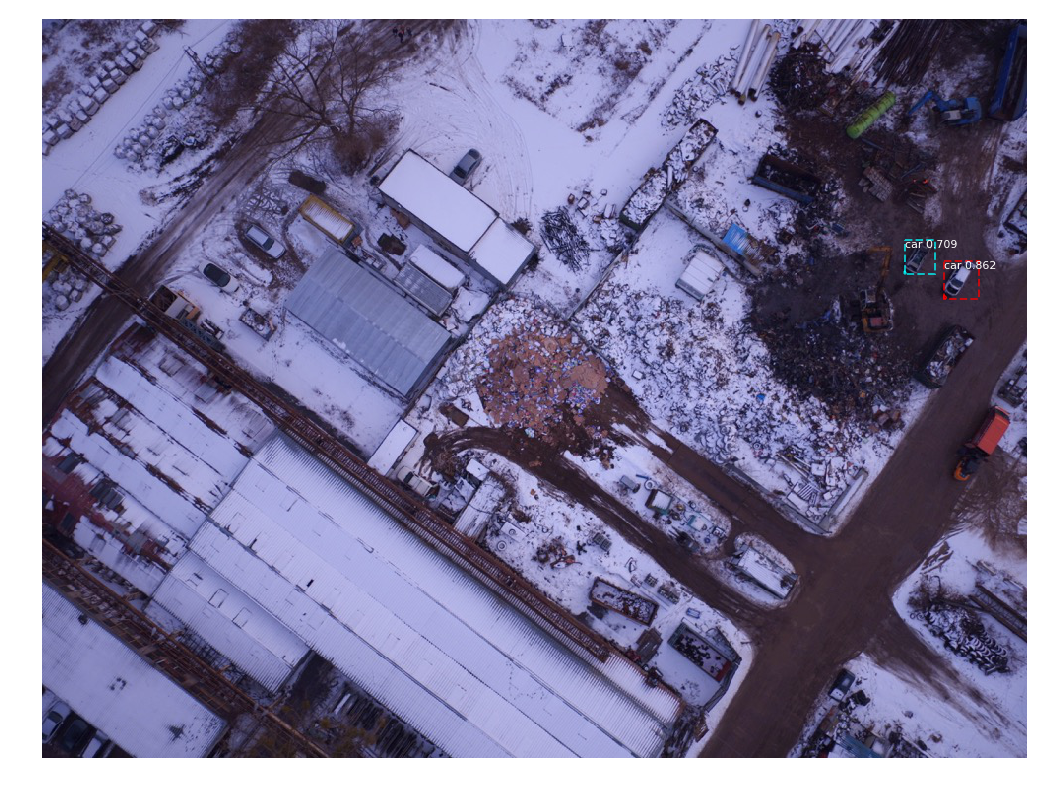

In [10]:
# Example prediction with loaded weights, which are loaded from .model_path file.
# Predictions can be visualized or not, depending on visualize_predictions setting.
# For predictions list of class_names should be provided, which correspond to configuration set in GISSConfig.

# mrcnn_checkpoints_filename = 'logs/giss_depth_cw1020180520T1335/mask_rcnn_giss_depth_cw10_0005.h5'  # Prediction weights filename, should be specified by hand at this point.
mrcnn_checkpoints_filename = 'logs/giss_depth_cw0120180521T1531/mask_rcnn_giss_depth_cw01_0005.h5'  # Prediction weights filename, should be specified by hand at this point.


class_names = ['BG', 'car', 'building', 'human', 'truck', 'container', 'winter_car']
api_training.model_path = mrcnn_checkpoints_filename
mrcnn_model_trained = api_training.load_model(inference_config)


if mode == 'train':
    # image = dataset_val.image_info[0]['image']  # for in-memory MRCNN dataset definition
    image = pd.read_pickle(dataset_val.image_info[0]['path'])  # for out-of-memory MRCNN dataset definition
if mode == 'test':
    # image = dataset_test.image_info[0]['image']  # for in-memory MRCNN dataset definition
    image = pd.read_pickle(dataset_test.image_info[0]['path'])  # for out-of-memory MRCNN dataset definition

img_preds = api_training.predict_image(image, mrcnn_model_trained, class_names, 
                                       visualize_predictions=True)

In [13]:
df_preds = api_training.create_predictions_df('asd', img_preds)
print('Resulting predictions dataframe:\n{}\n'.format(df_preds))

Predictions DF for filename: asd
Resulting predictions dataframe:
   ymin  xmin  ymax  xmax filename  class  confidence   x   y
0   244   915   283   951      asd      1    0.862004  36  39
1   223   875   258   906      asd      1    0.708792  31  35



In [18]:
json_preds = df_preds.to_json(orient='records', lines=False)[1:-1]

In [19]:
json_preds

'{"ymin":244,"xmin":915,"ymax":283,"xmax":951,"filename":"asd","class":1,"confidence":0.8620041609,"x":36,"y":39},{"ymin":223,"xmin":875,"ymax":258,"xmax":906,"filename":"asd","class":1,"confidence":0.7087920308,"x":31,"y":35}'